# start

In [130]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm as tqdm
import matplotlib.pyplot as plt

In [81]:
home_path = '/cluster/raid/home/f80878961/'
script_path ='{}scripts/'.format(home_path)
working_path = '/cluster/raid/home/f80878961/beestrong/ont/'
fastq_path = '{}fastq/'.format(working_path)
mm2_path = '{}minimap2/'.format(working_path)
kraken2_path = '{}kraken2/'.format(working_path)
bracken_path = '{}bracken/'.format(working_path)

if not os.path.exists(mm2_path):
    os.mkdir(mm2_path)
if not os.path.exists(fastq_path):
    os.mkdir(fastq_path)
if not os.path.exists(kraken2_path):
    os.mkdir(kraken2_path)
if not os.path.exists(bracken_path):
    os.mkdir(bracken_path)

In [89]:
metadata_xlsx = '{}ES203_Overview_Sequencing_Runs_New_GridION.xlsx'.format(working_path)

metadata_df = pd.read_excel(metadata_xlsx, sheet_name='Sheet2', engine='openpyxl')
metadata_df.columns = metadata_df.iloc[14]
metadata_df = metadata_df.iloc[15:].reset_index(drop=True)

# list of beestrong sample ids for array job
bs_ids = [x.replace('-', '_') for x in metadata_df['Sample']]
bs_ids_file = '{}bs_ids.txt'.format(working_path)
# with open(bs_ids_file, 'w') as outf:
#     outf.write('\n'.join(bs_ids))

In [47]:
# # merge files
# for r in tqdm(metadata_df.iterrows()):
#     barcode_nr = r[1]['#']
#     bs_id = r[1]['Sample'].replace('-', '_')
#     with open('{}{}.fastq.gz'.format(fastq_path, bs_id), 'wb') as outf:
#         for fn in glob.glob('{}fastq_pass/barcode{}/*.fastq.gz'.format(working_path, '%02d' % barcode_nr)):
#             with open(fn, 'rb') as inf:
#                 outf.write(inf.read())

# minimap2

TO DO :

- multiQC although I like this nanoplot
- align to bee genome (maybe minimap2 or long-read specific aligner to avoid latter fuss)
- Kraken2 + Bracken (read first on application to long reads) 

In [143]:
def write_mm2_script_home(script_fn, array_str):
    runstr="""#!/bin/bash -l
#SBATCH --array=ARRAY_STR
#SBATCH --nodes=1
#SBATCH --ntasks=8
#SBATCH --mem=30g
#SBATCH --time=24:00:00
#SBATCH --job-name=mm2
#SBATCH --output=%x_%A_%a.out
#SBATCH --error=%x_%A_%a.err

modulesld
ebld
module use /software/anaconda3/envs/eb/easybuild/modules/all
ml minimap2
ml SAMtools

idx_path=$1
fastq_path=$2
mm2_path=$3
bs_ids_file=$4
ref_name=$5

# getting bs_id
bs_id=$(sed -n ${SLURM_ARRAY_TASK_ID}'{p;q}' ${bs_ids_file})
mm2_prefix=${mm2_path}${bs_id}_${ref_name}

fastq=$fastq_path${bs_id}.fastq.gz
ls -lh $fastq

echo "1. minimap2"
minimap2 -t 8 -a -x map-ont ${idx_path} $fastq > ${mm2_prefix}.sam

echo "2. export unmapped reads"
samtools fastq -n -f 4 ${mm2_prefix}.sam > ${mm2_prefix}_unmapped.fastq

echo "3. SAM to BAM"
samtools view -S -b ${mm2_prefix}.sam > ${mm2_prefix}.bam

echo "4. export stats"
samtools stats ${mm2_prefix}.bam | grep ^SN | cut -f 2- > ${mm2_prefix}.stats

echo "5. compress"
gzip -f ${mm2_prefix}_unmapped.fastq
rm -f ${mm2_prefix}.sam

echo DONE""".replace(
    'ARRAY_STR', array_str)
    with open(script_fn, 'w') as outf:
        outf.write(runstr)

In [59]:
idx_path = "/cluster/raid/home/f80878961/data/minimap2_indexes/bee.mmi"
ref_name = "bee"

In [60]:
mm2_script_home = '{}mm2_home.run'.format(script_path)
write_mm2_script_home(mm2_script_home, '2-20')

In [61]:
%%bash -s "$mm2_script_home" "$idx_path" "$fastq_path" "$mm2_path" "$bs_ids_file" "$ref_name"
cd $4
sbatch $1 $2 $3 $4 $5 $6

Submitted batch job 79555


Map against varroa genome

In [146]:
idx_path = "/cluster/raid/home/f80878961/data/minimap2_indexes/varroa.mmi"
ref_name = "varroa"
mm2_script_home = '{}mm2_home.run'.format(script_path)
write_mm2_script_home(mm2_script_home, '2-20')

In [147]:
%%bash -s "$mm2_script_home" "$idx_path" "$fastq_path" "$mm2_path" "$bs_ids_file" "$ref_name"
cd $4
sbatch $1 $2 $3 $4 $5 $6

Submitted batch job 79617


# Kraken2

In [71]:
def write_kraken2_script(kraken2_script_fn, array_str):
    kraken2_runstr="""#!/bin/bash -l
#SBATCH --array=ARRAY_STR
#SBATCH --nodes=1
#SBATCH --ntasks=8
#SBATCH --mem=400g
#SBATCH --time=02:00:00
#SBATCH --job-name=kraken2
#SBATCH --output=%x_%A_%a.out
#SBATCH --error=%x_%A_%a.err

modulesld
ebld
module use /software/anaconda3/envs/eb/easybuild/modules/all
conda activate planb
which kraken2

kdb_path=$1
kdb_name=$2
mm2_path=$3
kraken2_path=$4
bs_ids_file=$5

# getting bs_id
bs_id=$(sed -n ${SLURM_ARRAY_TASK_ID}'{p;q}' ${bs_ids_file})

fastq=${mm2_path}${bs_id}_bee_unmapped.fastq.gz
ls -lh $fastq

out_file_id=${kraken2_path}${bs_id}_nonbee
echo $out_file_id

echo '1. kraken2'
kraken2 --threads 8 --db ${kdb_path}${kdb_name} --confidence 0.05 --gzip-compressed --output ${out_file_id}.kraken2 --report ${out_file_id}.k2report ${fastq}

echo DONE""".replace('ARRAY_STR', array_str)
    with open(kraken2_script_fn, 'w') as outf:
        outf.write(kraken2_runstr)

In [75]:
# most efficient is actually to run things in home 
kraken2_script = '{}kraken2.run'.format(script_path)
write_kraken2_script(kraken2_script, '2-20')

In [76]:
shared_data_path = '/cluster/raid/home/f80878961/data/'
kdb_path = '{}krakdb/'.format(shared_data_path)
kdb_name = 'corent'

In [77]:
%%bash -s "$kraken2_script" "$kdb_path" "$kdb_name" "$mm2_path" "$kraken2_path" "$bs_ids_file"
cd $5
sbatch $1 $2 $3 $4 $5 $6

Submitted batch job 79576


# Bracken

In [83]:
def write_bracken_script(kraken2_script_fn, array_str):
    kraken2_runstr="""#!/bin/bash -l
#SBATCH --array=ARRAY_STR
#SBATCH --nodes=1
#SBATCH --ntasks=1
#SBATCH --mem=20g
#SBATCH --time=01:00:00
#SBATCH --job-name=bracken
#SBATCH --output=%x_%A_%a.out
#SBATCH --error=%x_%A_%a.err

modulesld
ebld
module use /software/anaconda3/envs/eb/easybuild/modules/all
conda activate planb
which bracken

kdb_path=$1
kdb_name=$2
kraken2_path=$3
bracken_path=$4
bs_ids_file=$5

# getting bs_id
bs_id=$(sed -n ${SLURM_ARRAY_TASK_ID}'{p;q}' ${bs_ids_file})
file_id=${bs_id}_nonbee
k2report_fn=${kraken2_path}${file_id}.k2report
bracken_fn=${bracken_path}${file_id}_S.bracken
breport_fn=${bracken_path}${file_id}_S.breport

ls -lh $k2report_fn
echo $bracken_fn
echo $breport_fn

echo '1. bracken'
bracken -d ${kdb_path}${kdb_name} -i $k2report_fn -r 300 -l S -t 10 -o $bracken_fn -w $breport_fn

echo DONE""".replace('ARRAY_STR', array_str)
    with open(kraken2_script_fn, 'w') as outf:
        outf.write(kraken2_runstr)

In [86]:
bracken_script = '{}bracken.run'.format(script_path)
write_bracken_script(bracken_script, '3-20')

In [87]:
%%bash -s "$bracken_script" "$kdb_path" "$kdb_name" "$kraken2_path" "$bracken_path" "$bs_ids_file"
cd $5
sbatch $1 $2 $3 $4 $5 $6

Submitted batch job 79597


# Varroa abundance

In [99]:
def get_total_read_nr(mm2_path, bs_id):
    with open('{}{}_bee.stats'.format(mm2_path, bs_id), 'r') as inf:
        return int(inf.readline().split('raw total sequences:')[1].split()[0])

In [113]:
def parse_kreport(kraken_path, bs_id):
    kreport_fn = '{}{}_nonbee.k2report'.format(kraken_path, bs_id)
    if not os.path.exists(kreport_fn): 
        print('missing {}'.format(kreport_fn))
    with open(kreport_fn, 'r') as inf:
        ucseqs_nr = int(inf.readline().split()[1])
        cseqs_nr = int(inf.readline().split()[1])
    return ucseqs_nr, cseqs_nr

def parse_breport(bracken_path, bs_id, level, taxa):
    '''get read numbers for taxa'''
    breport_fn = '{}{}_nonbee_{}.breport'.format(bracken_path, bs_id, level)
    if not os.path.exists(breport_fn): 
        print('missing {}'.format(breport_fn))
    breport_df = pd.read_csv(breport_fn, header=None, sep='\t')
    breport_df[5] = [x.lstrip() for x in breport_df[5].to_list()]
    return breport_df[breport_df[5].isin(taxa)].set_index(5)[1].to_dict()

def get_classified_read_nr(mm2_path, kraken_path, bracken_path, bs_id_str, level):
    '''
    Equals the total number of read in the raw fasta minus the number of unclassified reads by Bracken.
    For a subsample, I multiple the total number of reads by the sampling fraction (similar to subsampling reads before mapping with bowtie2)
    '''
    total_read_nr = get_total_read_nr(mm2_path, bs_id_str)
    kraken_ucread_nr, kraken_cread_nr = parse_kreport(kraken_path, bs_id_str)
    bracken_cread_nr = parse_breport(bracken_path, bs_id_str, level, ['root'])['root']
    bracken_ucread_nr = kraken_cread_nr - bracken_cread_nr
    return total_read_nr - kraken_ucread_nr - bracken_ucread_nr

def get_bracken_df(mm2_path, kraken2_path, bracken_path, bs_id_str, level):
    '''
    parse bracken file
    '''
    # parse bracken output
    bracken_fn = '{}{}_nonbee_{}.bracken'.format(bracken_path, bs_id_str, level)
    if not os.path.exists(bracken_fn): 
        print('missing {}'.format(bracken_fn))
    bracken_df = pd.read_csv(bracken_fn, sep='\t')

    ## calculate original read numbers
    # number of reads classified by kraken2 + bracken AND by bowtie2 --> to calculate relative abundance
    classified_read_nr = get_classified_read_nr(mm2_path, kraken2_path, bracken_path, bs_id_str, level)
    
    # classified reads - non bee reads
    honeybee_read_nr = classified_read_nr - bracken_df[bracken_df['name'] != 'Apis mellifera']['new_est_reads'].sum()

    # recompute relative abundance
    bracken_df['fraction_total_reads'] = bracken_df['new_est_reads'].to_numpy() / classified_read_nr
    
    # calculate Aitchison log ratio
    bracken_df['ratio_honeybee'] = bracken_df['new_est_reads'].to_numpy() / honeybee_read_nr
    bracken_df['log_ratio_honeybee'] = np.log(bracken_df['new_est_reads'].to_numpy() / honeybee_read_nr)
    
    # log ratio of absolute abundances == log ratio of relative abundances
    assert np.all(np.round(bracken_df['log_ratio_honeybee'].to_numpy(), 10) == np.round(np.log(bracken_df['fraction_total_reads'].to_numpy() / (honeybee_read_nr / classified_read_nr)), 10))

    return bracken_df

In [171]:
def get_stat(mm2_path, bs_id, ref_name, stat):
    '''
    bases mapped:
    reads mapped:
    '''
    with open('{}{}_{}.stats'.format(mm2_path, bs_id, ref_name), 'r') as inf:
        l = inf.readline()
        while not l.startswith(stat):
            l = inf.readline()
        return int(l.split(stat)[1].split()[0])

def get_varroa_bee_ratio_ONT(mm2_path, bs_id, stat):
    bee_read_nr = get_stat(mm2_path, bs_id, 'bee', stat)
    varroa_read_nr = get_stat(mm2_path, bs_id, 'varroa', stat)
    return varroa_read_nr / bee_read_nr

In [114]:
# parse bracken tables
level = 'S'

df_list = []
for bs_id in tqdm(bs_ids):
    df = get_bracken_df(mm2_path, kraken2_path, bracken_path, bs_id, level)
    df = df[['name', 'taxonomy_id', 'fraction_total_reads', 'new_est_reads', 'log_ratio_honeybee', 'ratio_honeybee']]
    df.insert(0, 'Colony', ['{}'.format(bs_id) for i in range(len(df))])
    df_list.append(df)

brack_df = pd.concat(df_list).rename(columns={'name': 'Taxon', 
                                              'taxonomy_id': 'TaxID', 
                                              'fraction_total_reads': 
                                              'Relative abundance', 'new_est_reads': 
                                              'Read number', 'ratio_honeybee': 
                                              'Ratio Honeybee', 'log_ratio_honeybee': 
                                              'Log Ratio Honeybee'}).reset_index().drop(columns=['index'])

brack_df

100%|██████████| 20/20 [00:00<00:00, 168.42it/s]


,Colony,Taxon,TaxID,Relative abundance,Read number,Log Ratio Honeybee,Ratio Honeybee
0,BS18_0007,Gilliamella apicola,1196095,0.009586,50638,-4.599924,0.010053
1,BS18_0007,Gilliamella apis,1970738,0.003842,20296,-5.514202,0.004029
2,BS18_0007,Gilliamella sp. B3022,2817969,0.000398,2105,-7.780311,0.000418
3,BS18_0007,Gilliamella sp. ESL0443,2704655,0.000196,1036,-8.489259,0.000206
4,BS18_0007,Gilliamella sp. ESL0441,2704654,0.000018,94,-10.889087,0.000019
...,...,...,...,...,...,...,...
1667,BS18_0182,Apis mellifera filamentous virus,1100043,0.001754,5452,-6.299927,0.001836
1668,BS18_0182,Caudoviricetes sp.,2832643,0.000225,698,-8.355446,0.000235
1669,BS18_0182,Ariapiscaud virus 4,3375903,0.000010,31,-11.469677,0.000010
1670,BS18_0182,Bacteriophage sp.,38018,0.000256,796,-8.224065,0.000268


In [178]:
get_stat(mm2_path, 'BS18_0167', 'varroa', 'bases mapped:')

118108926

In [179]:
get_stat(mm2_path, 'BS18_0167', 'bee', 'bases mapped:')

3370980783

In [180]:
varroa_df = brack_df[brack_df['Taxon']=='Varroa destructor'][['Colony', 'Relative abundance', 'Ratio Honeybee']].rename(columns={
    'Relative abundance': 'Varroa relative abundance (ONT Kraken2)', 'Ratio Honeybee': 'Varroa Honeybee Ratio (ONT Kraken2)'}).merge(
    pheno_df[['Colony', 'Varroa relative abundance', 'v_pho', 'v_mito']].rename(columns={
    'Varroa relative abundance': 'Varroa relative abundance (Illumina Kraken2)', 'v_pho': 'Nr. Varroa/100 bees'}), how='left', on='Colony')

In [181]:
varroa_df['Varroa Honeybee Ratio (ONT)'] = varroa_df['Colony'].map(lambda x: get_varroa_bee_ratio_ONT(mm2_path, x, 'bases mapped (cigar):'))

In [182]:
varroa_df

,Colony,Varroa relative abundance (ONT Kraken2),Varroa Honeybee Ratio (ONT Kraken2),Varroa relative abundance (Illumina Kraken2),Nr. Varroa/100 bees,v_mito,Varroa Honeybee Ratio (ONT)
0,BS18_0007,0.000008,0.000008,0.000014,0.669856,0.014900,0.017064
1,BS18_0043,0.000024,0.000026,0.000034,5.945946,0.044459,0.016537
2,BS18_0048,0.000055,0.000058,0.000081,7.765452,0.108162,0.019971
3,BS18_0028,0.000190,0.000208,0.000216,17.785016,0.314848,0.022358
4,BS18_0029,0.000180,0.000190,0.000194,20.355412,0.277086,0.020560
5,BS18_0030,0.000111,0.000120,0.000133,14.417910,0.199606,0.019214
6,BS18_0031,0.000136,0.000146,0.000144,11.810700,0.181908,0.020413
7,BS18_0033,0.000062,0.000066,0.000075,9.736842,0.096045,0.020994
8,BS18_0037,0.000166,0.000176,0.000180,20.840630,0.216516,0.023898
9,BS18_0038,0.000019,0.000021,0.000021,2.568807,0.021139,0.021511


0.9274299392990075


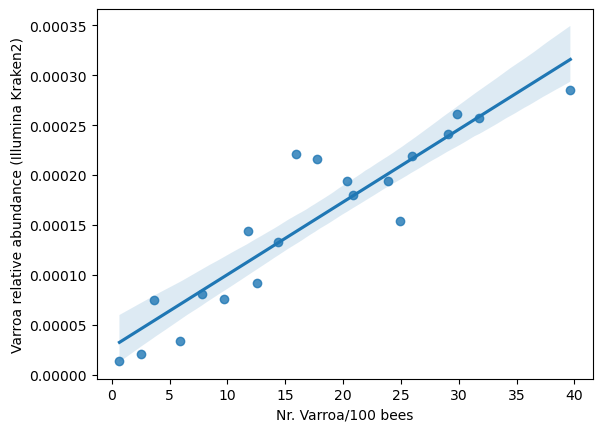

In [176]:
x = 'Nr. Varroa/100 bees'
y = 'Varroa relative abundance (Illumina Kraken2)'

print(varroa_df[x].corr(varroa_df[y]))

sns.regplot(data=varroa_df, x=x, y=y)
plt.show()

0.8997392055762179


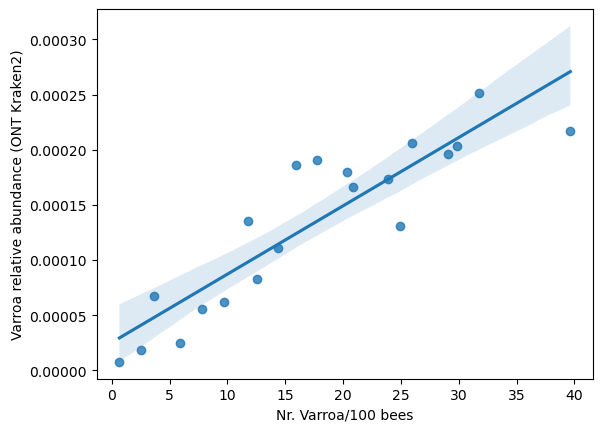

In [135]:
x = 'Nr. Varroa/100 bees'
y = 'Varroa relative abundance (ONT Kraken2)'

print(varroa_df[x].corr(varroa_df[y]))

sns.regplot(data=varroa_df, x=x, y=y)
plt.show()

0.8903594754098295


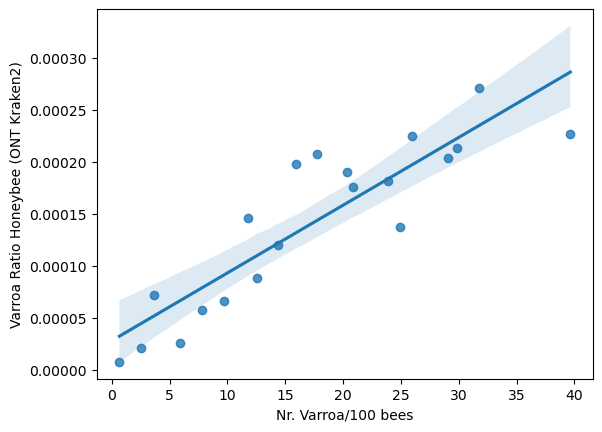

In [137]:
x = 'Nr. Varroa/100 bees'
y = 'Varroa Ratio Honeybee (ONT Kraken2)'

print(varroa_df[x].corr(varroa_df[y]))

sns.regplot(data=varroa_df, x=x, y=y)
plt.show()

0.90045772770892


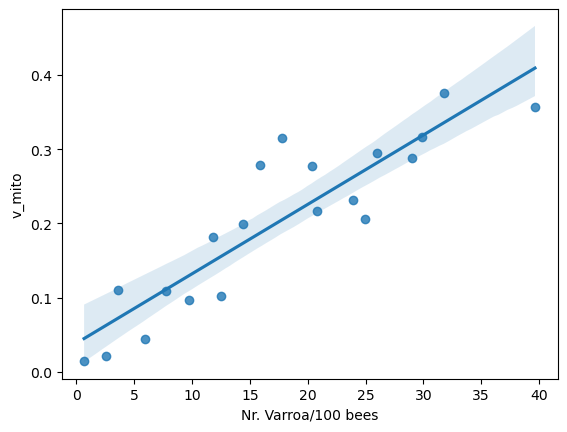

In [136]:
x = 'Nr. Varroa/100 bees'
y = 'v_mito'

print(varroa_df[x].corr(varroa_df[y]))

sns.regplot(data=varroa_df, x=x, y=y)
plt.show()

0.983880024927288


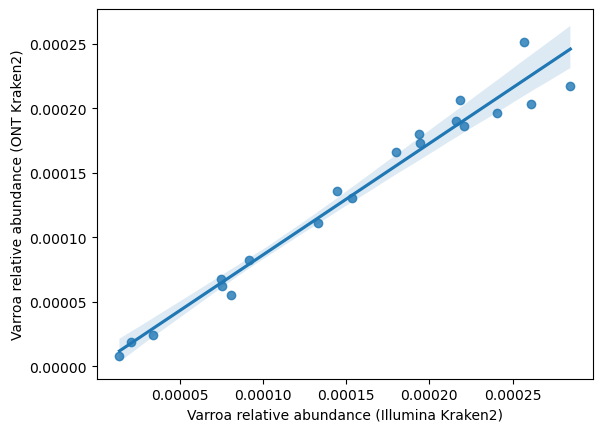

In [138]:
x = 'Varroa relative abundance (Illumina Kraken2)'
y = 'Varroa relative abundance (ONT Kraken2)'

print(varroa_df[x].corr(varroa_df[y]))

sns.regplot(data=varroa_df, x=x, y=y)
plt.show()

0.9851508335896134


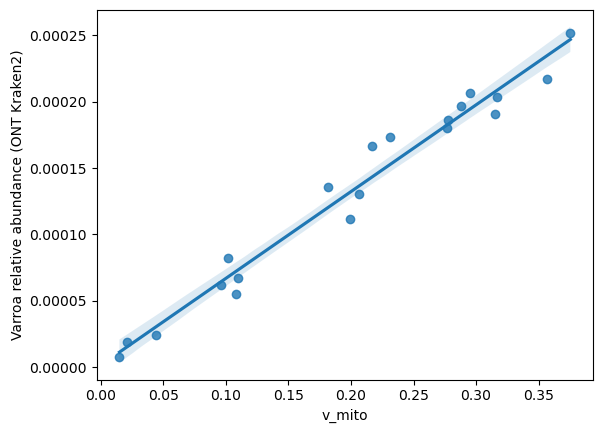

In [141]:
x = 'v_mito'
y = 'Varroa relative abundance (ONT Kraken2)'

print(varroa_df[x].corr(varroa_df[y]))

sns.regplot(data=varroa_df, x=x, y=y)
plt.show()

0.42784134635645255


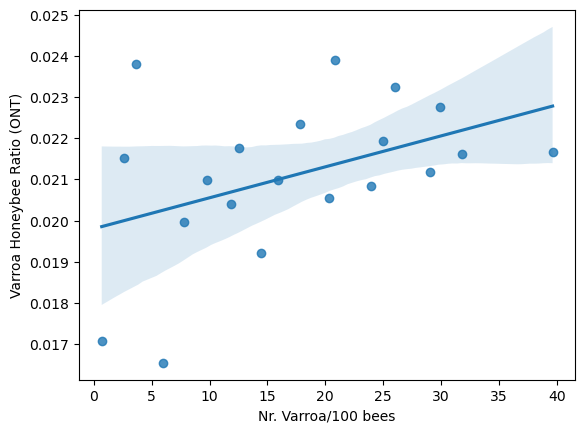

In [183]:
x = 'Nr. Varroa/100 bees'
y = 'Varroa Honeybee Ratio (ONT)'

print(varroa_df[x].corr(varroa_df[y]))

sns.regplot(data=varroa_df, x=x, y=y)
plt.show()

- I did not apply any filtering / trimming / error correction on ONT reads
- Kraken2 and Bracken not tuned for this dataset (e.g., smaller k-mer size to handle error rate and length parameters of Bracken)
- Not sure if counting at the read level instead of the base/k-mer level is correct for variable length sequences
- I should probably use tools specific to Long reads like BugSeq as Kraken2 and Bracken were designed for short reads
- An attractive option is to simply align to varroa genome for varroa estimation --> somehow not working (neither for ratio of read mapped nor base mapped) maybe why they used mitochondrial genome...
- 

# end